# GPM data combining and conversion

#### Combining the gpm highres nc4 datasets for each year and exporting to a singular classic netcdf dataset (individual for each year) to be used as input for nctoolkits cdo for regridding to lowres dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline
%config IPCompleter.greedy = True

In [2]:
# from dask.diagnostics import ProgressBar

In [5]:
import seaborn as sns
# Use seaborn style defaults and set default figure size
# plt.style.use('seaborn-pastel')
# sns.set_theme(style="ticks")
plt.style.use('nature')

In [6]:
# Colormap selection
xr.set_options(cmap_divergent='RdBu_r', cmap_sequential='Blues')

In [13]:
ds1 = xr.open_dataset('./data/GPM_data/gpm_2013.nc')

In [14]:
# ds1

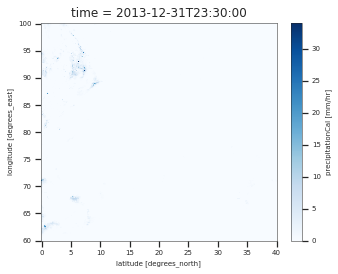

In [16]:
ds1.precipitationCal.isel(time = -1).plot(size=4)